Generate a coxPH fitted model

Identify relevant covariates, then re-fit the data generating the residuals

Pass the residuals into the NN with slide images to find if we can improve on the baseline model



In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path
from lifelines.utils import concordance_index, survival_table_from_events
from lifelines import CoxPHFitter, AalenAdditiveFitter
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


In [3]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp_cox"


for d in [EXP_PATH]:
    if not d.exists():
        d.mkdir()

In [28]:
slides = pd.read_csv(LIVER_PATH/'slides.csv')
slides = slides.loc[slides.sample_type_id.isin([1])]
slide_level = 'level_1'
slides['days_proxy'] = slides.days_to_death.fillna(slides.days_to_last_follow_up)
slides = slides.loc[slides.days_proxy.notnull()]
slides['death'] = True
slides.loc[slides.days_to_last_follow_up.notnull(),'death'] = False    
slides['death'] = slides['death'].astype(int)

slides['sec_loc'] = (slides.section_location == 'TOP').astype(int)

features =  [    
    #'percent_tumor_nuclei',
    #'percent_tumor_cells',
    #'percent_normal_cells',
    'age_at_diagnosis',
    #'creation_datetime',
    #'sec_loc'
]

targets = [
    'days_proxy',
    'death',  
]
scaler = MinMaxScaler()
fit_df = slides.loc[slides.sample_type_id == 1, features+targets].dropna()
fit_df.loc[:,features] = scaler.fit_transform(fit_df[features])


In [29]:
surv_table = survival_table_from_events(fit_df['days_proxy'], fit_df['death'])
print(surv_table.head())


          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             5         0         5       396      396
1.0             1         0         1         0      391
6.0             3         0         3         0      390
8.0             1         0         1         0      387
9.0             3         1         2         0      386


In [30]:
model = CoxPHFitter()
model.fit(fit_df, 'days_proxy', event_col='death')

<lifelines.CoxPHFitter: fitted with 396 observations, 289 censored>

In [31]:
model.print_summary()

n=396, number of events=107

                   coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95    
age_at_diagnosis 1.7388     5.6903    0.5870 2.9620 0.0031      0.5882      2.8893  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.586


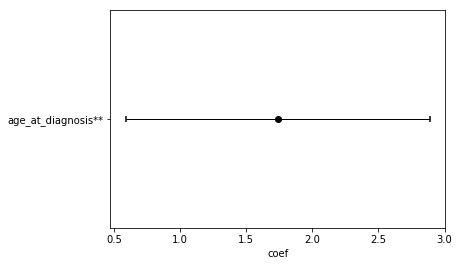

In [32]:
model.plot()

In [68]:
fit_df.head()

,age_at_diagnosis,days_proxy,death,preds,resid
0,0.637482,6.0,0,2057.149747,-2051.149747
1,0.497867,279.0,0,2294.762996,-2015.762996
2,0.419948,2202.0,0,2419.854314,-217.854314
3,0.607510,472.0,0,2109.362959,-1637.362959
4,0.636949,951.0,0,2058.083289,-1107.083289


In [43]:
model.hazards_

,age_at_diagnosis
coef,1.738757


In [81]:
np.exp(model.hazards_.values[0][0] * fit_df.age_at_diagnosis).head()

0    3.029586
1    2.376598
2    2.075470
3    2.875746
4    3.026778
Name: age_at_diagnosis, dtype: float64

In [84]:
model.baseline_hazard_.loc[fit_df.days_proxy].head()

,baseline hazard
event_at,
6.0,0.0
279.0,0.0
2202.0,0.0
472.0,0.0
951.0,0.0


In [85]:
np.exp(model.hazards_.values[0][0] * fit_df.age_at_diagnosis).head()

0    3.029586
1    2.376598
2    2.075470
3    2.875746
4    3.026778
Name: age_at_diagnosis, dtype: float64

In [88]:
cox_hazzard_prob = model.baseline_hazard_.loc[fit_df.days_proxy].values.squeeze() \
                        * np.exp(model.hazards_.values[0][0] * fit_df.age_at_diagnosis).values
plt.hist(cox_hazzard_prob)

(array([372.,  15.,   4.,   0.,   0.,   2.,   1.,   1.,   0.,   1.]),
 array([0.        , 0.06954507, 0.13909013, 0.2086352 , 0.27818027,
        0.34772534, 0.4172704 , 0.48681547, 0.55636054, 0.62590561,
        0.69545067]),
 <a list of 10 Patch objects>)

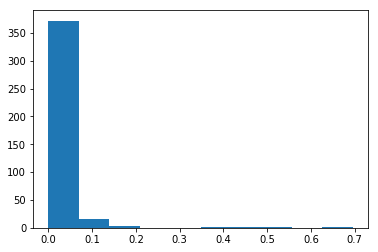

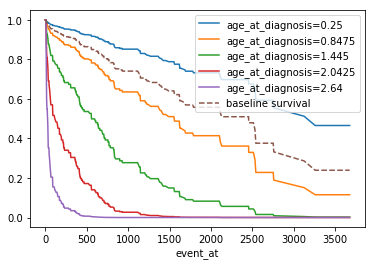

In [33]:
model.plot_covariate_groups('age_at_diagnosis' ,np.linspace(0.25,2.64,5))

What are the predictions when you account for the age factor? What are the residual errors?

In [34]:
print(fit_df.head())


   age_at_diagnosis  days_proxy  death
0          0.637482         6.0      0
1          0.497867       279.0      0
2          0.419948      2202.0      0
3          0.607510       472.0      0
4          0.636949       951.0      0


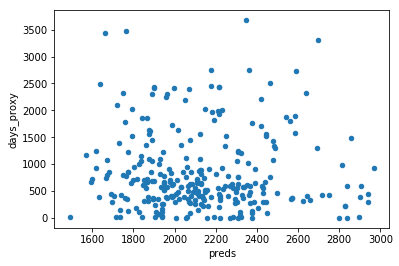

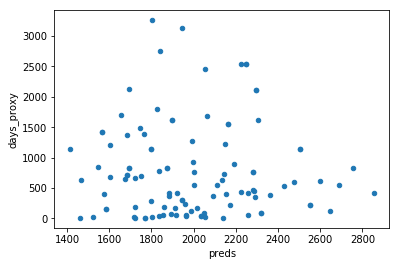

In [35]:
X = fit_df.drop(['days_proxy','death'],axis=1)
fit_df['preds'] = model.predict_expectation(X)

fit_df.loc[fit_df.death == 0,['preds','days_proxy','death']].plot(kind='scatter',x='preds',y='days_proxy')
fit_df.loc[fit_df.death != 0,['preds','days_proxy','death']].plot(kind='scatter',x='preds',y='days_proxy')

In [36]:
concordance_index(fit_df.days_proxy, coxPH_predicted_survival, fit_df.death)

0.6566921303620666

In [37]:
fit_df['resid'] = fit_df.days_proxy - fit_df.preds

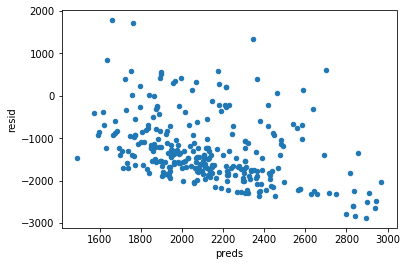

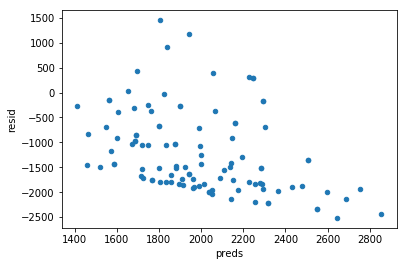

In [104]:
fit_df.loc[fit_df.death == 0,['resid','preds','death']].plot(kind='scatter',x='preds',y='resid')
fit_df.loc[fit_df.death != 0,['resid','preds','death']].plot(kind='scatter',x='preds',y='resid')

Will CIndex get better if we do a regression on the errors?  Then remove the obvious linear trend and scale properly?  or will CIndex all stay the same?


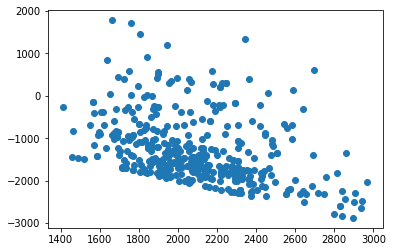

In [106]:
plt.scatter(fit_df.preds,fit_df.resid)

In [109]:
import statsmodels.formula.api as sm

ols_model = sm.ols(formula='resid ~ preds',data=fit_df).fit()
ols_pred_from_res = ols_model.predict(fit_df.preds)
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  resid   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     75.93
Date:                Thu, 21 Jun 2018   Prob (F-statistic):           8.25e-17
Time:                        14:18:25   Log-Likelihood:                -3173.3
No. Observations:                 396   AIC:                             6351.
Df Residuals:                     394   BIC:                             6359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    911.6236    253.424      3.597      0.000     413.392    1409.855
preds         -1.0444      0.120     -8.714      0.000      -1.280      -0.809
==============================================================================
Omnibus:                       93.947   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.192
Skew:                           1.370   Prob(JB):                     1.35e-36
Kurtosis:                       4.582   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

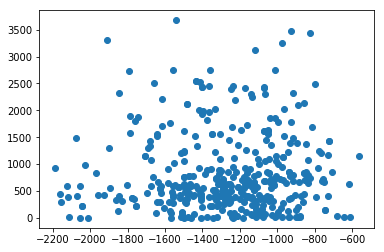

In [110]:
plt.scatter(ols_pred_from_res,fit_df.days_proxy)

In [111]:
concordance_index(fit_df.days_proxy, ols_pred_from_res, fit_df.death)

0.4135741083939791